# Introductory applied machine learning (INFR10069)

# Lab 1: Data analysis and visualisation

In this lab we work with a spam filtering dataset. We will perform exploratory data analysis, visualisation and, finally, we learn how to perform classification tasks using Naive Bayes. For this, we will use the the packages introduced in Lab 1, and `scikit-learn` package (`sklearn`): a machine learning library for Python which works with numpy array, and pandas DataFrame objects.

**Please Note**: Throughout this lab we make reference to [`methods`](https://en.wikipedia.org/wiki/Method_%28computer_programming%29) for specific objects e.g. "make use of the predict method of the MultinomialNB classifier". If you get confused, refer to the documentation and just ctrl+f for the object concerned:
* [Scikit-learn API documentation](http://scikit-learn.org/0.19/modules/classes.html) 
* [Seaborn API documentation](https://seaborn.github.io/api.html)
* [Matplotlib Pyplot documentation](http://matplotlib.org/2.2.3/api/pyplot_summary.html)
* [Pandas API documentation](http://pandas.pydata.org/pandas-docs/version/0.23.4/api.html)
* [Numpy documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/)

There are also tonnes of great examples online; googling key words with the word "example" will serve you well.

First, we need to import the packages (run all the code cells as you read along):

In [35]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

*Clarification*:

* The `%matplotlib inline` command is a special ipython [built in magic command](http://ipython.readthedocs.io/en/stable/interactive/magics.html) which forces the matplotlib plots to be rendered within the notebook.

## Spambase dataset

The [Spambase](http://archive.ics.uci.edu/ml/datasets/Spambase) dataset consists of tagged emails from a single email account. You should read through the description available for this data to get a feel for what you're dealing with. We have downloaded the dataset for you.

You will find the dataset located at `./datasets/spambase.csv` (the `datasets` directory is adjacent to this file). Execute the cell below to load the csv into in a pandas DataFrame object. 

In [36]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'spambase.csv')
spambase = pd.read_csv(data_path, delimiter = ',')

We have now loaded the data. Let's get a feeling of what the data looks like by using the `head()` method.

In [37]:
spambase.head(5) # Display the 5 first rows of the dataframe

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0,1.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0,1.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0,1.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0,1.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0,1.0


### ========== Question 1 ==========

**a)** Display the number of attributes in the dataset (i.e. number of columns).

In [38]:
# Your Code goes here:
spambase.columns.size, spambase.shape[1]

(58, 58)

**b)** Display the number of observations (i.e. number of rows).

In [39]:
# Your Code goes here:
len(spambase.index), spambase.shape[0]

(4601, 4601)

**c)** Display the mean and standard deviation of each attribute.

In [40]:
# Your Code goes here:
spambase.describe()[1:3]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698


We now want to *remove* some of the attributes from our data. There are various reasons for wanting to do so, for instance we might think that these are not relevant to the task we want to perform (i.e. e-mail classification) or they might have been contaminated with noise during the data collection process.

## Data cleaning

### ========== Question 2 ==========

**a)** Delete the `capital_run_length_average`, `capital_run_length_longest` and  `capital_run_length_total` attributes. 
*Hint*: You should make use of the [`drop`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html) method. 

*Tip*: some pandas methods have the argument `inplace` which you can use to determine whether they alter the object they are called upon and return nothing, or return a new object. This is particularly useful if you are dealing with huge datasets where you would typically want to operate `inplace`.

In [41]:
# Your Code goes here:
spambase.drop(columns=["capital_run_length_average", "capital_run_length_longest", "capital_run_length_total"], inplace=True)

**b)** Display the new number of attributes. Does it look like what you expected?

In [42]:
# Your Code goes here:
spambase.head(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,is_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,1.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,1.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,1.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,1.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,1.0


The remaining attributes represent relative frequencies of various important words and characters in emails. This is true for all attributes except `is_spam` which represents whether the e-mail was annotated as spam or not. So each e-mail is represented by a 55 dimensional vector representing whether or not a particular word exists in an e-mail. This is the so called [bag of words](http://en.wikipedia.org/wiki/Bag_of_words_model) representation and is clearly a very crude approximation since it does not take into account the order of the words in the emails.

### ========== Question 3 ==========

Now let's get a feeling of the distribution of ham (i.e. valid) vs. spam emails. We can do this by using a [countplot](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) in seaborn. In the code cell below, write code to:

**a)** Produce a seaborn [countplot](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) object that shows the distribution of ham/spam e-mails. Assign it to a variable (e.g. `ax` to emphasise it is a [matplotlib.axes.Axes](https://matplotlib.org/2.2.3/api/axes_api.html) object)
  
**b)** In the same cell, modify the labels on the x axis (`xticklabels`) to `Ham` and `Spam` (by default they should be set to `0.0` and `1.0`). *Hint: Axes objects have a [`set_xticklabels`](https://matplotlib.org/2.2.3/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html#matplotlib.axes.Axes.set_xticklabels) method!* 
  
**c)** Finally, again in the same cell, remove the `is_spam` label from the x axis (`xlabel`) since it does not add any information to the graph

You may notice `<matplotlib.text.Text at ...memory_location...>` printed by the ipython notebook. This is just because the notebook is inferring how to display the last object in the cell. To explicitly plot the Axes object, use the `matplotlib.pyplot.show()` method at the very end of the cell, i.e. `plt.show()` (we imported the `matplotlib.pyplot` module as `plt` above)

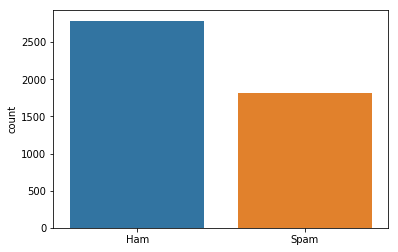

In [43]:
# Your Code goes here:
cp = sns.countplot(x="is_spam", y=None, hue=None, data=spambase, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
cp.axes.set_xticklabels(["Ham", "Spam"])
plt.xlabel("")
plt.show()

Now we want to simplify the problem by transforming our dataset. We will replace all numerical values which represent word frequencies with a binary value representing whether each word was present in a document or not.

### ========== Question 4 ==========

**a)** Crate a new dataframe called `spambase_binary` from `spambase`. *Hint*: Look into the [`copy`](http://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.copy.html) method in pandas. 

*Tip*: Be careful, in python, unless you explictly say not to, assigment is typically just reference e.g.
```python
i = [1, 3]
j = i
i[1] = 5
print(j)
```
outputs:
```
[1, 5]
```

In [44]:
# Your Code goes here:
spambase_binary = spambase.copy()
spambase_binary.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,is_spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,1.0
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,1.0
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,1.0
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,1.0
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,1.0
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.0,0.0,0.00,0.223,0.0,0.000,0.000,0.000,1.0
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.00,0.0,0.0,0.00,0.054,0.0,0.164,0.054,0.000,1.0
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.00,0.0,0.0,0.00,0.206,0.0,0.000,0.000,0.000,1.0
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.00,0.0,0.0,0.00,0.271,0.0,0.181,0.203,0.022,1.0
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.00,0.0,0.0,0.04,0.030,0.0,0.244,0.081,0.000,1.0


**b)** Convert all attributes in `spambase_binary` to Boolean values: 1 if the word or character is present in the email, or 0 otherwise.

In [45]:
# Your Code goes here:
spambase_binary[spambase_binary>0] = 1

**c)** Display the 5 last observations of the transformed dataset.

In [69]:
# Your Code goes here:
spambase_binary.tail(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,is_spam
4596,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4598,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4599,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4600,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Visualisation

Now we want to get a feeling for how the presence or absence of some specific words could affect the outcome (whether an email is classifed as *ham* or *spam*). We will be focusing on three specific words, namely `make`, `internet` and `edu`.

### ========== Question 5 ==========

**a)** Using seaborn, produce one figure with three [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot), one for each of the frequency variables for the words `make`, `internet` and `edu`. For each variable, the count plot should have two bars: the number of emails containing the word (i.e. the variable = 1), and the number not containing that word (i.e. the variable = 0).

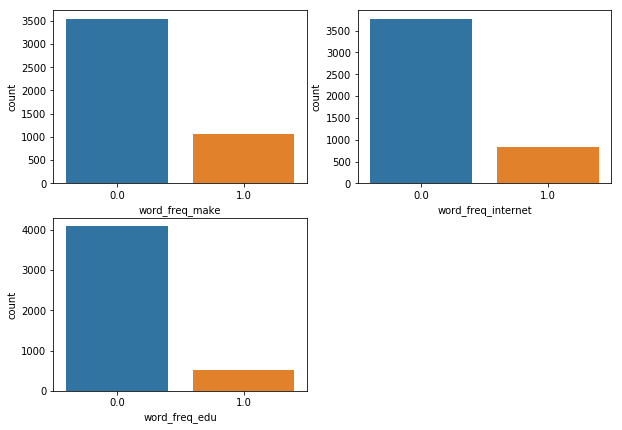

In [47]:
# Your Code goes here:
fig, ax = plt.subplots(figsize=(10,7))
plt.subplot(2,2,1)
sns.countplot(x="word_freq_make", y=None, hue=None, data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.subplot(2,2,2)
sns.countplot(x="word_freq_internet", y=None, hue=None, data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.subplot(2,2,3)
sns.countplot(x="word_freq_edu", y=None, hue=None, data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.show()

**b)** Repeat the above but split the bars showing the proportion of emails that are spam/ham. *Hint*: This only requires you to use the `hue` input argument to use different colours for the `is_spam` variable.

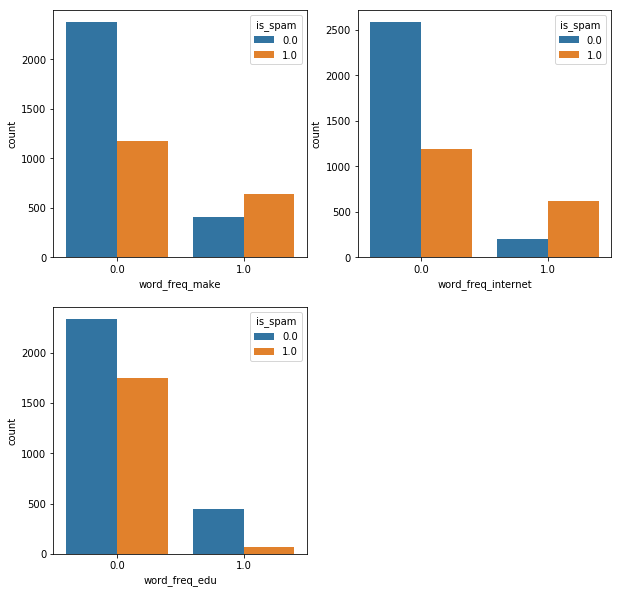

In [48]:
# Your Code goes here:
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
sns.countplot(x="word_freq_make", y=None, hue="is_spam", data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.subplot(2,2,2)
sns.countplot(x="word_freq_internet", y=None, hue="is_spam", data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.subplot(2,2,3)
sns.countplot(x="word_freq_edu", y=None, hue="is_spam", data=spambase_binary, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None)
plt.show()

## Multinomial Naive Bayes classification

Given the transformed dataset, we now wish to train a Naïve Bayes classifier to distinguish spam from regular email by fitting a distribution of the number of occurrences of each word for all the spam and non-spam e-mails. Read about the [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) and the underlying assumption if you are not already familiar with it. In this lab we focus on the [Multinomial Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes). 

We will make use of the `MultinomialNB` class in `sklearn`. **Check out the user guide [description](http://scikit-learn.org/0.19/modules/naive_bayes.html#multinomial-naive-bayes) and [documentation](http://scikit-learn.org/0.19/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) to familiarise yourself with this class.**

All classifiers in `sklearn` implement a `fit()` and `predict()` [method](https://en.wikipedia.org/wiki/Method_%28computer_programming%29). The first learns the parameters of the model and the latter classifies inputs. For a Naive Bayes classifier, the [`fit`](http://scikit-learn.org/0.19/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit) method takes at least two input arguments `X` and `y`, where `X` are the input features and `y` are the labels associated with each example in the training dataset (i.e. targets). 

As a first step we extract the input features and targets from the DataFrame. To do so, we will use the [`values`](http://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.values.html) property. For the input features we want to select all columns except `is_spam` and for this we may use the [`drop`](http://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.drop.html) method which discards the specified columns along the given axis. In fact, we can combine these two operations in one step.

### ========== Question 6 ==========

**a)** Create a Pandas DataFrame object `X` containing only the features (i.e. exclude the label `is_spam`). We need to do this as it is the input Scikit-learn objects expect for fitting. *Hint*: make use of the `drop` method.

In [49]:
# Your Code goes here:
X = spambase_binary.drop("is_spam",axis=1).values
X

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

**b)** Create a Pandas Series object `y` that contains only the label from `spambase_binary`.

In [50]:
# Your Code goes here:
y = pd.Series(spambase_binary["is_spam"])

**c)** Display the dimensionality (i.e. `shape`) of each of the two arrays. *Hint:* The shape of `X` and `y` should be `(4601, 54)` and `(4601,)` respectively.

In [51]:
# Your Code goes here:
X.shape, y.shape

((4601, 54), (4601,))

### ========== Question 7 ==========

Now we want to train a Multinomial Naive Bayes classifier. Initialise a `MultinomialNB` object and [`fit`](http://scikit-learn.org/0.19/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit) the classifier using the `X` and `y` arrays extracted in the cell above.

In [52]:
# Your Code goes here:
clf = MultinomialNB()
clf.fit(X,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Model evaluation

We can evaluate the classifier by looking at the classification accuracy, and the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

Scikit-learn model objects have built in scoring methods. The default [`score` method for `MultinomialNB`](http://scikit-learn.org/0.19/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score) estimates the classification accuracy score. Alternatively, you can compute the prediction for the training data and make use of the [`accuracy_score`](http://scikit-learn.org/0.19/modules/generated/sklearn.metrics.accuracy_score.html) function (that is in fact what the classifier's `score()` method does under the hood).

Scikit-learn also has a [`confusion_matrix`](http://scikit-learn.org/0.19/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) implementation which returns a numpy array (square matrix) of dimensionality `K`, where `K` is the number of classes (2 in our case).

### ========== Question 8 ========== 

**a)** Display the log-prior probabilities for each class. *Hint:* use tab-completion to figure out which attribute of the `MultinomialNB` structure you are interested in.

In [53]:
# Your Code goes here:
clf.class_log_prior_

array([-0.50094918, -0.93129074])

**b)** Predict the output of the classifier by using the training data as input. *Hint*: make use of the `predict` method of the `MultinomialNB` classifier.

In [54]:
# Your Code goes here:
pred = clf.predict(X)

**c)** Compute the classification accuracy on the training data by either using the `accuracy_score` metric or the `score` method of the `MultinomialNB`. 

In [55]:
# Your Code goes here:
clf.score(X,y)

0.8924146924581613

**d)** Compute the resulting confusion_matrix by using the builtin scikit-learn class and display the result. 

In [76]:
# Your Code goes here:
confusion = confusion_matrix(y, pred)
confusion

array([[2412,  376],
       [ 119, 1694]], dtype=int64)

**e)** Normalise the produced confusion matrix by the true class and display the result. In other words, the matrix should show you what proportion of `Ham` emails were predicted as `Ham`/`Spam` and vice versa.

In [77]:
# Your Code goes here:
cm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
cm

array([[0.8651363 , 0.1348637 ],
       [0.06563707, 0.93436293]])

**f)** By making use of the `plot_confusion_matrix` provided below, visualise the normalised confusion matrix. Plot the appropriate labels on both axes by making use of the `classes` input argument.

In [78]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

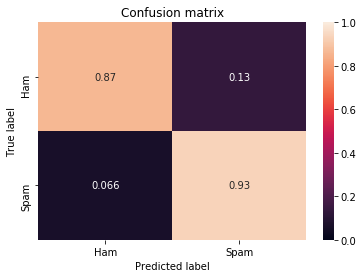

In [79]:
# Your Code goes here:
plot_confusion_matrix(cm, classes=["Ham", "Spam"])

### ========== Question 9 ==========

Study the output produced, most importantly the percentages of correctly and incorrectly classified instances. You probably will notice that your classifer does rather well despite making a very strong assumption on the form of the data. If we didn't make this assumption, what would be the main practical problems? *Hint*: If you've forgotten the assumption of the Naive Bayes model, check wikipedia and/or sklearn documentation.

***Your answer goes here:***
The main practical problem if we didn't make the Naive Bayes assumption (conditional independence given the label) is theat we would have to estimate a full convariance esitimate might be dominated by noise. Assuming conditional independence allows us  to estimate a diagonal cov. matrix i.e.estimate a variance for each variable independently and assume all cov. between distinct variables are 0.

### ========== Question 10 ==========

The empirical log probability of input features given a class $P\left(x_i  |  y\right)$ is given by the attribute `feature_log_prob` of the classifier. For each feature there are two such conditional probabilities, one for each class. 

**a)** What dimensionality do you expect the `feature_log_prob_` array to have? Why?

***Your answer goes here:***
（54，2）. 54 features and 2 classes

**b)** Inspect the log probabilities of the features. Verify that it has the expected dimensionality (i.e. `shape`).

In [60]:
# Your Code goes here:
flp = clf.feature_log_prob_
flp.shape

(2, 54)

**c)** Create a list of the names of the features that have higher log probability when the email is `Ham` than `Spam` i.e. what features imply an email is more likely to be `Ham`? *Hint:* There are a many ways to do this. Try it on your own then, if you get stuck, you can do it using index numbers (look up [`np.argwhere`](http://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argwhere.html)), or using a boolean mask (look up [pandas indexing](http://pandas.pydata.org/pandas-docs/version/0.23.4/indexing.html)). The column names of a Pandas DataFrame are contained in the `columns` attribute.

In [83]:
# Your Code goes here:
log_p = flp[1]/flp[0]
spambase.columns[np.nonzero(log_p>1)]

Index(['word_freq_will', 'word_freq_you', 'word_freq_hp', 'word_freq_hpl',
       'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs',
       'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415',
       'word_freq_85', 'word_freq_technology', 'word_freq_1999',
       'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs',
       'word_freq_meeting', 'word_freq_original', 'word_freq_project',
       'word_freq_re', 'word_freq_edu', 'word_freq_table',
       'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_['],
      dtype='object')

### ========== Question 11 ==========

For the final part of this section we will now pretend we are spammers wishing to fool a spam checking system based on Naïve Bayes into classifying a spam e-mail as ham (i.e. a valid e-mail). For this we will use a test set consisting of just one data point (i.e. e-mail). This tiny dataset is called `spambase_test` and has already been pre-processed for you which means that the redundant attributes have been removed and word frequencies have been replaced by word presence/absence.

**a)** Load `./datasets/spambase_test.csv` dataset into a new pandas structure

In [86]:
# Your Code goes here:
spambase_test_loc = os.path.join(os.getcwd(), 'datasets', 'spambase_test.csv')
spambase_test = pd.read_csv(spambase_test_loc)

**b)** Use `spambase_test` to create a pandas DataFrame object X_test, contatining the test features, and pandas Series object y_test, containing the test outcome

In [87]:
# Your Code goes here:
X_test = spambase_test.drop("is_spam", axis=1).values
y_test = pd.Series(spambase_test["is_spam"])
X_test, y_test

(array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int64), 0    1
 Name: is_spam, dtype: int64)

**c)** Feed the input features into the classifier and compare the outcome to the true label. Make sure you don't feed the target into the classifier as you will receive an error (why?). Does the classifer classify the spam e-mail correctly?

In [88]:
# Your Code goes here:
clf.predict(X_test), clf.score(X_test, y_test)

(array([1.]), 1.0)

**d)** Pick one (perhaps random) attribute that has higher probability for the ham class (using your feature names in Question 10c) and set the corresponding value in `X_test` to 1. Now predict the new outcome. Has it changed? If not, keep modifying more attributes until you have achieved the desired outcome (i.e. model classifies the e-mail as ham).

In [91]:
# Your Code goes here:
for idx in np.nonzero(log_p>1):
    X_test[0][idx]= 1
    if clf.predict(X_test) != y_test.iloc[0]:
        print('The word "', idx[10:], '" did the trick!')
        break

X_test, clf.predict(X_test), clf.score(X_test, y_test)

The word " [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] " did the trick!


(array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int64), array([0.]), 0.0)

### ========== Question 12 ==========

**This is an extension for people keen to learn more advanced plotting.** We'll be happy to discuss your conclusions in the lab.

**a)** Create a plot of the spam/ham log probabilities for all of the features. This will help you find the spammiest/hammiest words to use in your emails! *Hint*: you can do this however you like, but try 'adapting' [this matplotlib demo](https://matplotlib.org/2.2.3/gallery/statistics/barchart_demo.html?highlight=bar%20chart)

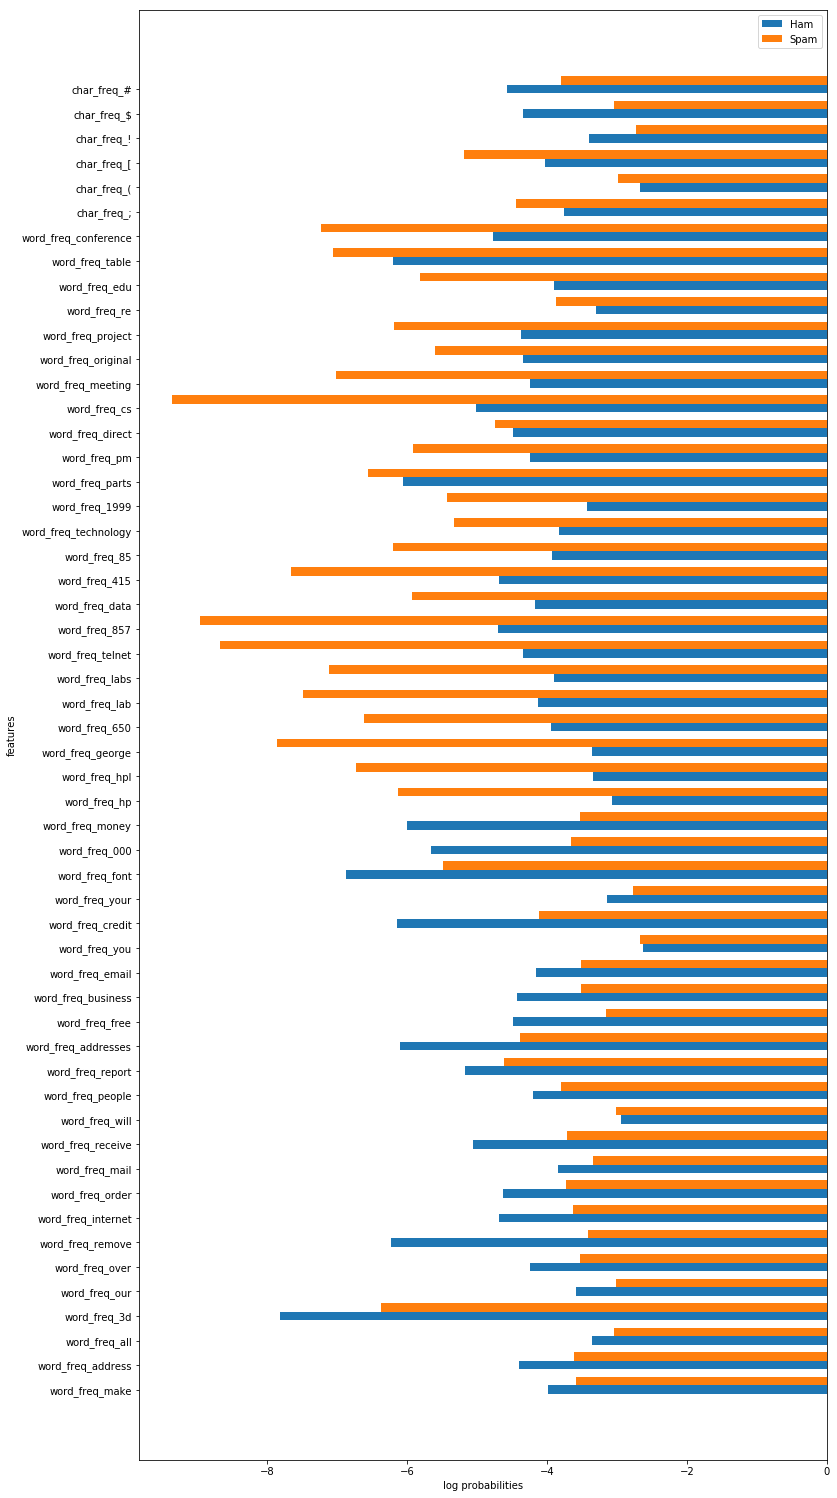

In [111]:
# Your Code goes here:
fig, ax = plt.subplots()

col = spambase.drop(columns="is_spam").columns.values
index = np.arange(len(col))
bar_width = 0.35

ham_rects = ax.barh(index, flp[0], bar_width)
spam_rects = ax.barh(index + bar_width, flp[1], bar_width)

ax.set_ylabel('features')
ax.set_xlabel('log probabilities')
ax.set_yticks(index)
ax.set_yticklabels(col)
ax.legend((ham_rects[0], spam_rects[0]), ('Ham', 'Spam'), loc="best")

fig.tight_layout()
fig.set_figwidth(15)
fig.set_figheight(25)
plt.show()

**b)** The features are in the order they appear in the dataset. Can you order them by probability of being `Ham`?

In [110]:
# Your Code goes here:
df = pd.DataFrame(flp[0]).T
df.columns = col
sort_ft = df.sort_values(0,1,ascending=False)
sort_ft

,word_freq_you,char_freq_(,word_freq_will,word_freq_hp,word_freq_your,word_freq_re,word_freq_hpl,word_freq_all,word_freq_george,char_freq_!,...,word_freq_report,word_freq_000,word_freq_money,word_freq_parts,word_freq_addresses,word_freq_credit,word_freq_table,word_freq_remove,word_freq_font,word_freq_3d
0,-2.621847,-2.67314,-2.936219,-3.064091,-3.14718,-3.296645,-3.346344,-3.360456,-3.361749,-3.394625,...,-5.167841,-5.655319,-6.004695,-6.060784,-6.100005,-6.140827,-6.205366,-6.227838,-6.876534,-7.814803


**c)** What about ordering by the absolute difference between `Ham` and `Spam` log probability?

In [68]:
# Your Code goes here:
dfc = pd.DataFrame(np.abs(flp[0]-flp[1])).T
dfc.columns = col
dfc.sort_values(0,1,ascending=False)

,word_freq_george,word_freq_cs,word_freq_telnet,word_freq_857,word_freq_hpl,word_freq_lab,word_freq_labs,word_freq_hp,word_freq_415,word_freq_remove,...,word_freq_mail,word_freq_parts,word_freq_people,word_freq_make,word_freq_your,word_freq_all,char_freq_(,word_freq_direct,word_freq_will,word_freq_you
0,4.494786,4.345796,4.32876,4.261239,3.37521,3.36566,3.210974,3.057843,2.971712,2.813955,...,0.511864,0.496467,0.405876,0.399409,0.384396,0.324203,0.309046,0.257954,0.075254,0.048545
